In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def minimal_alpha_beta(Y, grid_size, penalty):
    alphas = np.linspace(0,1,grid_size)
    betas = np.linspace(0,1,grid_size)
    
    min_alpha = 0.0
    min_beta = 0.0
    min_obj = np.square( np.diff( np.array(Y)) ).sum()
    
    for alpha in alphas:
        for beta in betas:
            sum_squares = 0.0
            level = Y[0]
            trend = 0.0

            for t in range(1, len(Y)):
                sum_squares = sum_squares + np.square(Y[t]-level-trend)
                old_level = level 
                level = (1-alpha)*Y[t]+alpha*(level + trend)
                trend = beta*(level - old_level )+(1-beta)*trend
                
            obj = sum_squares + penalty*beta

            if obj < min_obj:
                min_alpha = alpha
                min_beta = beta
                min_obj = obj
            
    return [min_alpha,min_beta]

def holt_filter(Y,alpha,beta):
    
    level = [Y[0]]
    trend = [0]
    
    for t in range(1,len(Y)):
        level.append((1-alpha)*Y[t] + alpha*(level[-1]+trend[-1] ) )
        trend.append(beta*(level[-1]-level[-2]) +(1-beta)*trend[-1])
        
    filter_df = pd.DataFrame(columns = ['Y','level','trend'])
    filter_df['Y'] = Y
    filter_df['level'] = level
    filter_df['trend'] = trend
    filter_df['forecast']  = (filter_df['level']+filter_df['trend']).shift(1)
    
    return filter_df

In [3]:
# data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/exp_smooth_lasso/air_passanger_data.xlsx')
# data = pd.read_excel('C:/Users/michelj8/Documents/data/female_birth_cali.xlsx')
m3_df = pd.read_excel( 'C:/Users/michelj8/Downloads/M3C.xlsx', sheet_name = 'M3Year')

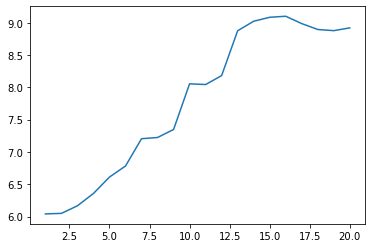

In [8]:
ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Unnamed: 5']).loc[7].dropna()
np.log(ts).plot()
Y = list(np.log(ts))

In [9]:
minimal_alpha_beta( Y ,50, 0.0)

[0.3061224489795918, 0.5714285714285714]

In [10]:
holt_df = holt_filter(Y, 0.3061224489795918, 0.5714285714285714)

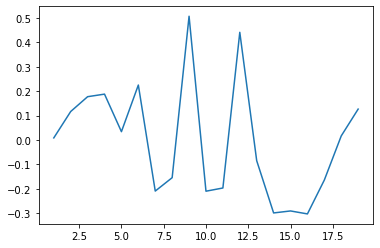

In [11]:
(holt_df['Y']-holt_df['forecast']).plot()

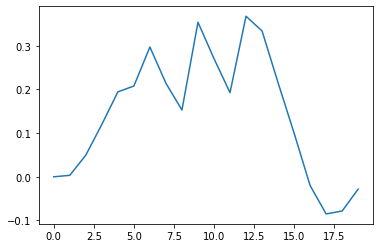

In [12]:
holt_df['trend'].plot()

# Study the LASSO on the whole sample

In [13]:
opt_param_df = pd.DataFrame(columns = ['alpha','beta'])

for penalty in np.linspace(0,5.0, 200):
    opt_param_df.loc[penalty] = minimal_alpha_beta( list(np.log(ts)) ,50, penalty)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize = (18,6))

opt_param_df.plot(x='alpha',y='beta', ax = ax)
ax.legend('')
ax.set_ylabel('beta')

In [ ]:
sse_df = pd.DataFrame(columns = ['penalty','sse']).set_index('penalty')

for penalty in opt_param_df.index:
    holt_df = holt_filter(Y,opt_param_df.loc[penalty,'alpha'], opt_param_df.loc[penalty,'beta'])
    sse_df.loc[penalty] = np.square(holt_df['Y'] - holt_df['forecast']).sum()

In [ ]:
sse_df.plot()

# Backtest Method

In [14]:
opt_param_df = pd.DataFrame(columns = ['alpha','beta'])

for penalty in np.linspace(0,5.0, 200):
    opt_param_df.loc[penalty] = minimal_alpha_beta( Y[0:8] ,50, penalty)

Text(0, 0.5, 'beta')

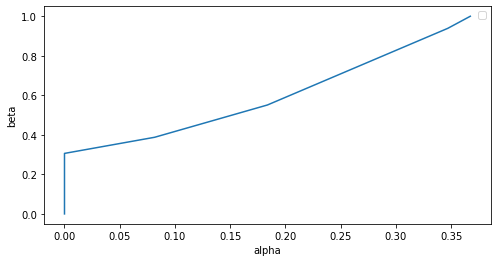

In [27]:
fig, ax = plt.subplots(figsize = (8,4))
opt_param_df.plot(x = 'alpha',y='beta', ax = ax)
ax.legend('')
ax.set_ylabel('beta')

In [15]:
sse_df = pd.DataFrame(columns = ['penalty','sse']).set_index('penalty')

for penalty in opt_param_df.index:
    holt_df = holt_filter(Y,opt_param_df.loc[penalty,'alpha'], opt_param_df.loc[penalty,'beta'])
    sse_df.loc[penalty] = np.square( (holt_df['Y'] - holt_df['forecast'])[8:16]).sum()

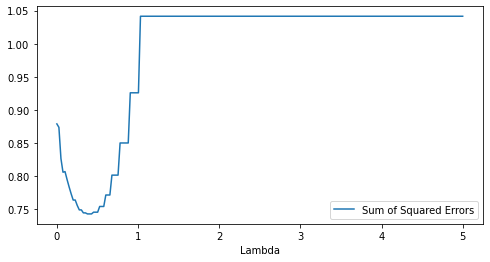

In [32]:
fig, ax = plt.subplots(figsize = (8,4))
sse_df.plot(ax = ax)
ax.legend(['Sum of Squared Errors'])
ax.set_xlabel('Lambda')

opt_penalty = sse_df.idxmin()[0]

In [33]:
opt_penalty

0.3768844221105528

In [38]:
comparison_df = pd.DataFrame(columns = ['Y','Holt','LASSO'])

grid_size = 150
# for penalty in [0,opt_penalty]:
#     params = minimal_alpha_beta( Y[0:16] ,25, penalty)
#     holt_df = holt_filter(Y, params[0], params[1])
#     print(np.square( (holt_df['Y'] - holt_df['forecast'])[16:]).sum())

penalty = 0.0
params = minimal_alpha_beta( Y[0:16] ,grid_size, penalty)
holt_df = holt_filter(Y, params[0], params[1])
print(params,  np.square( (holt_df['Y'] - holt_df['forecast'])[16:]).sum())
comparison_df['Holt'] = holt_df['forecast']

penalty = opt_penalty
params = minimal_alpha_beta( Y[0:16] ,grid_size, penalty)
holt_df = holt_filter(Y, params[0], params[1])
print(params, np.square( (holt_df['Y'] - holt_df['forecast'])[16:]).sum())
comparison_df['LASSO'] = holt_df['forecast']
comparison_df['Y'] = Y

[0.6375838926174496, 0.8590604026845637] 0.4423029288663591
[0.2348993288590604, 0.2348993288590604] 0.255528513671522


Text(0.5, 0, 'Time')

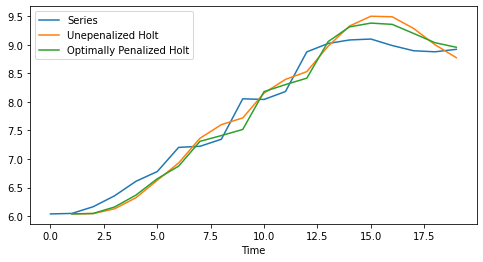

In [49]:
fig, ax = plt.subplots(figsize = (8,4))

comparison_df.plot(ax = ax)
ax.legend(['Series','Unepenalized Holt','Optimally Penalized Holt'])
ax.set_xlabel('Time')

In [45]:
print ( np.abs((comparison_df['Y'] - comparison_df['Holt']))[16:].mean())
print ( np.abs((comparison_df['Y'] - comparison_df['LASSO']))[16:].mean())

0.290847758545949
0.21710041957841186


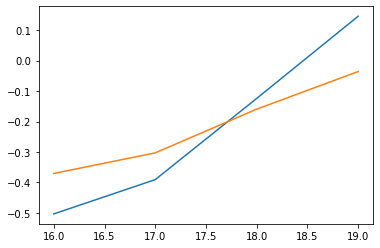

In [41]:
fig, ax = plt.subplots()

(comparison_df['Y'] - comparison_df['Holt'])[16:].plot(ax =ax)
(comparison_df['Y'] - comparison_df['LASSO'])[16:].plot(ax =ax)